# Predict Future Sales

Notes from the competition host:

*This challenge serves as final project for the "How to win a data science competition" Coursera course.*

*In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.*

*We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.*

*Submissions are evaluated by root mean squared error (RMSE). **True target values are clipped into [0,20] range**.*

*For each id in the test set, you must predict a total number of sales.*

# Importing libraries, data sets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd

pd.set_option('display.float_format',lambda x: '%.2f' %x)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1500)

import warnings

import sys
import calendar
import datetime
import os
# Input data files are available in the read-only '../input/' directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from itertools import product
import random
import gc
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from xgboost import XGBRegressor
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
%matplotlib inline
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using 'Save & Run All' 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Loading train and test sets. We have more input data than these two; however, due to high memory use of these files, I will import the rest of the data right when I need them.<br> In addition, to utilize the use of local variables and reduce memory footprint, I tried to wrap the code in functions.

In [3]:
random.seed(35)
  
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

A small utility function to downcast df as we're working with large amounts of data.

In [4]:
def downcast_df(df):
    
    before = df.memory_usage()
    
    cols_to_skip = df.isna().sum()[df.isna().sum()>0].index
    numcols=[col for col in df.select_dtypes('number').columns if col not in cols_to_skip]
    ints = df.select_dtypes(int).columns
    floats = df.select_dtypes(float).columns
    
    for col in ints:
        df[col] = pd.to_numeric(df[col].values, downcast='integer')
    for col in floats:
        df[col] = pd.to_numeric(df[col].values, downcast='float')
        
    after = df.memory_usage()
    reduction = (before-after)/before*100
    
    comparison = pd.concat([before,after,reduction],axis=1)
    comparison.columns = ['|before downcasting|','|after downcasting|','|reduction (%)|']
    
    print(f'Memory use: \n  {comparison}\n\n')
    
    return df

df = downcast_df(train)
df = downcast_df(test)

Memory use: 
                  |before downcasting|  |after downcasting|  |reduction (%)|
Index                            128                  128             0.00
date                        23486792             23486792             0.00
date_block_num              23486792              2935849            87.50
shop_id                     23486792              2935849            87.50
item_id                     23486792              5871698            75.00
item_price                  23486792             11743396            50.00
item_cnt_day                23486792             11743396            50.00


Memory use: 
           |before downcasting|  |after downcasting|  |reduction (%)|
Index                     128                  128             0.00
ID                    1713600               856800            50.00
shop_id               1713600               214200            87.50
item_id               1713600               428400            75.00




In [5]:
print(f'Train set contains {train.shape[0]} rows,{train.shape[1]} columns. \nTest set contains {test.shape[0]} rows, {test.shape[1]} columns.\n')
print(f'These are the features in TRAIN and NOT in TEST -> {set(train.columns) - set(test.columns)}.\nThese are the features in TEST and NOT in TRAIN -> {set(test.columns) - set(train.columns)}')

Train set contains 2935849 rows,6 columns. 
Test set contains 214200 rows, 3 columns.

These are the features in TRAIN and NOT in TEST -> {'item_cnt_day', 'date', 'item_price', 'date_block_num'}.
These are the features in TEST and NOT in TRAIN -> {'ID'}


In [6]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int8   
 2   shop_id         2935849 non-null  int8   
 3   item_id         2935849 non-null  int16  
 4   item_price      2935849 non-null  float32
 5   item_cnt_day    2935849 non-null  float32
dtypes: float32(2), int16(1), int8(2), object(1)
memory usage: 56.0+ MB


In [7]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int32
 1   shop_id  214200 non-null  int8 
 2   item_id  214200 non-null  int16
dtypes: int16(1), int32(1), int8(1)
memory usage: 1.4 MB


In [8]:
train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2927421,22.10.2015,33,28,19125,399.00,1.00
383191,17.04.2013,3,15,6027,299.00,1.00
2560785,23.04.2015,27,35,5361,28.00,1.00
914833,06.09.2013,8,28,8022,15.00,1.00
1426260,19.02.2014,13,54,15102,659.00,1.00


In [9]:
test.sample(5)

,ID,shop_id,item_id
141581,141581,57,226
191141,191141,46,9835
80499,80499,15,14765
66880,66880,24,1295
174517,174517,35,4143


In [10]:
train.drop(columns=['item_id','shop_id']).describe()

,date_block_num,item_price,item_cnt_day
count,2935849.00,2935849.00,2935849.00
mean,14.57,890.85,1.24
std,9.42,1729.80,2.62
min,0.00,-1.00,-22.00
25%,7.00,249.00,1.00
50%,14.00,399.00,1.00
75%,23.00,999.00,1.00
max,33.00,307980.00,2169.00


A few things to note:
* There are negative values under the sales quantity column (item_cnt_day). I assume they indicate returns..
* There is also negative item price. I assume this is an error and needs to be corrected.

Adding columns to the test dataframe to align it with the train df.

In [11]:
test = test.drop('ID', axis=1)

test['date'] = '01.11.2015'
test['date_block_num'] = 34
test['item_cnt_day'] = np.nan
test['item_price'] = np.nan

Taking a closer look at the record(s) with the negative price.

In [12]:
train[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00,1.00


Only one record. Checking other records for the same item and shop.

In [13]:
train[(train['item_id']==2973)&(train['shop_id']==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.00,1.00
67428,25.01.2013,0,32,2973,2499.00,1.00
67429,22.01.2013,0,32,2973,2499.00,1.00
67430,21.01.2013,0,32,2973,2499.00,1.00
67431,18.01.2013,0,32,2973,2499.00,1.00
67432,17.01.2013,0,32,2973,2499.00,1.00
67433,15.01.2013,0,32,2973,2499.00,3.00
187844,05.02.2013,1,32,2973,2499.00,1.00
187845,14.02.2013,1,32,2973,2499.00,1.00
484682,23.05.2013,4,32,2973,1249.00,1.00


Imputing the negative item price with the most common occurrance -> 2499

In [14]:
train.loc[train['item_price']<0,'item_price'] = 2499

Applying grouping to train and test dataframes so that they show monthly sales qty instead of daily.<br> This is because we're asked to provide the forecast at a monthly level. I am also resetting **daily** negative sales qty to 0, and clipping the **monthly** target value between 0 and 20 per the instructions.<br>

In [15]:
train.loc[train['item_cnt_day']<0, 'item_cnt_day'] = 0

train = train.groupby(
    by = ['date_block_num','shop_id','item_id'],as_index=False).agg(
    {'item_cnt_day':'sum','item_price':'mean','date':'first'})

train = train.rename(
    columns={'item_cnt_day':'item_cnt_month'})
test = test.rename(
    columns={'item_cnt_day':'item_cnt_month'})

train['item_cnt_month'] = train['item_cnt_month'].clip(0,20)

# Outlier Detection

Checking the item price for outliers

<ipython-input-16-e92b8da95c56>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


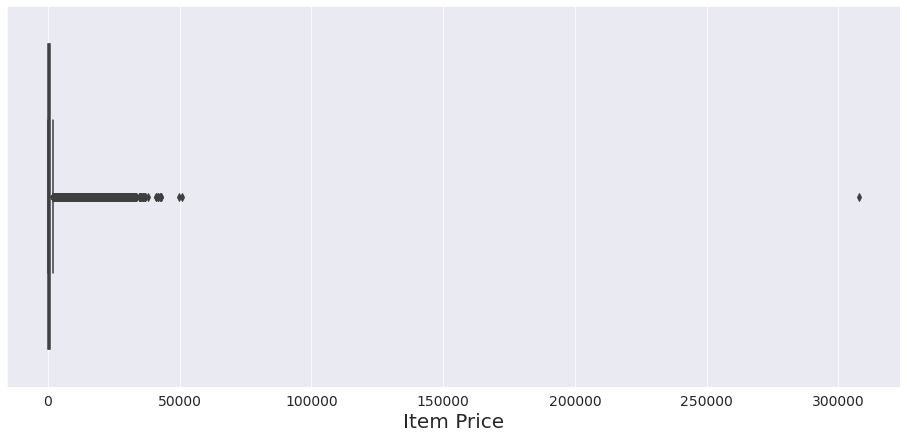

In [16]:
def plot_for_outlier(ft, name):
    sns.set_style("darkgrid")

    params={
        'axes.labelsize':20,
        'xtick.labelsize':14,
    }
    plt.rcParams.update(params)

    fig, ax = plt.subplots(figsize=(16,7))

    plot1 = sns.boxplot(x=train[ft])


    plot1.set_xlabel(name)


    return fig.show()

plot_for_outlier('item_price','Item Price')

In [17]:
train[train['item_price']>100000]

,date_block_num,shop_id,item_id,item_cnt_month,item_price,date
629348,11,12,6066,1.00,307980.00,13.12.2013


Removing one big outlier from the equation.

In [18]:
train = train[train['item_price']<100000]

<ipython-input-16-e92b8da95c56>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


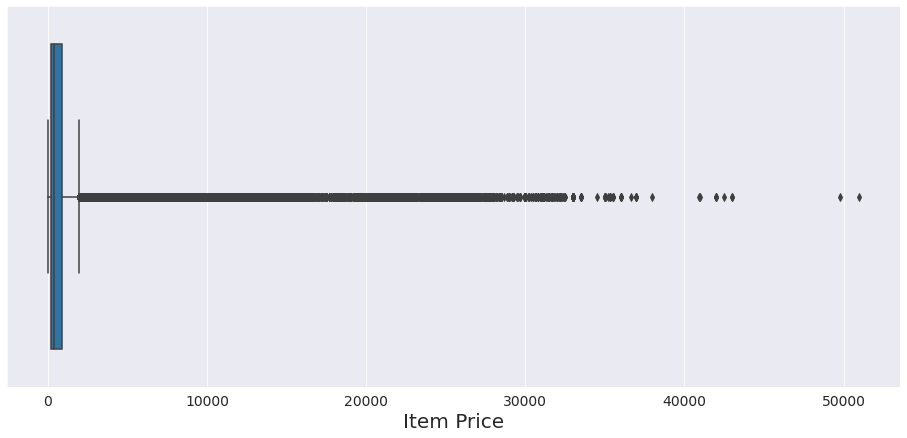

In [19]:
plot_for_outlier('item_price','Item Price')

Looks a bit better. <br>Checking sales qty for outliers now.

<ipython-input-16-e92b8da95c56>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


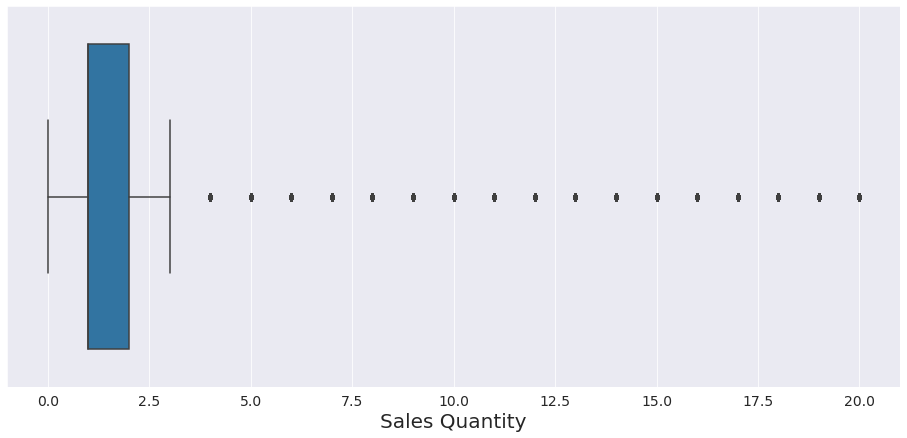

In [20]:
plot_for_outlier('item_cnt_month','Sales Quantity')

Nothing surprising here since we clipped target var between 0 and 20. Let's check the value counts within the sales quantity (item_cnt_month) column.

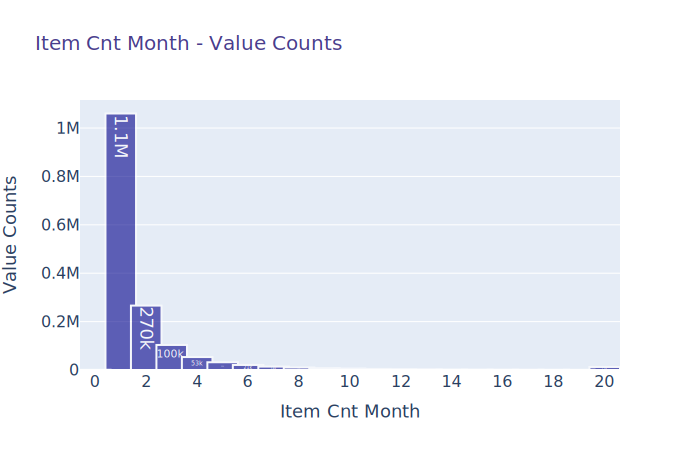

In [21]:
x = train['item_cnt_month'].value_counts().index
y = train['item_cnt_month'].value_counts().values

fig = go.Figure(data=[go.Bar(x=x, y=y, text=y,textposition='outside')])

fig.update_traces(marker_color='darkblue', marker_line_color='white',texttemplate='%{text:.2s}',width=1.2,
                  textfont=dict(size=18),textposition='inside',marker_line_width=2, opacity=0.6)


fig.update_xaxes(title_text='Item Cnt Month',titlefont=dict(size=18),nticks=20,tickfont=dict(size=16))
fig.update_yaxes(title_text='Value Counts',titlefont=dict(size=18),tickfont=dict(size=16))

fig.update_layout(height=700, width=900,
                  title=go.layout.Title(text='Item Cnt Month - Value Counts', 
                                        font=dict(size=20, color='darkslateblue')))

'''Remove "svg" inside the parantheses below to enable interactive plotting. 
For this you need a renderer that includes the embedded HTML/JavaScript 
that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
fig.show("svg")

A large majority of the monthly sales quantity are 1. We also have around 900 zero counts. The zeroes came to surface because we clipped the sales quantity in the previous steps. 

Plotting unique item counts, unique shop counts, and unique item/shop combinations per date block. Blue bar represents the test set.

In [22]:
def plot_counts(ft, name):    
    fig = plotly.graph_objects.Figure()

    vizdata = train.append(test, ignore_index=True).groupby(by=['date_block_num'], as_index=False)[ft].nunique()

    colors = ['indianred',] * vizdata.shape[0]
    colors[-1] = 'blue'

    fig.add_trace(go.Bar(x=vizdata['date_block_num'],y=vizdata[ft],width=0.9,
                             marker_color=colors,name='Unique' +name+ 'Count'))


    fig.update_xaxes(title_text='Date Block',titlefont=dict(size=20),
                     tickfont=dict(size=16))
    fig.update_yaxes(title_text='Total Unique '+name+' Count',titlefont=dict(size=20),nticks=8,
                     tickfont=dict(size=16))

    fig.update_layout(height=800, width=800,
                      title=go.layout.Title(text='Unique '+name+' Counts per Date Block (Incl. Test data)', 
                                            font=dict(size=20, color='darkslateblue')))
    '''Remove "svg" inside the parantheses below to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("svg")

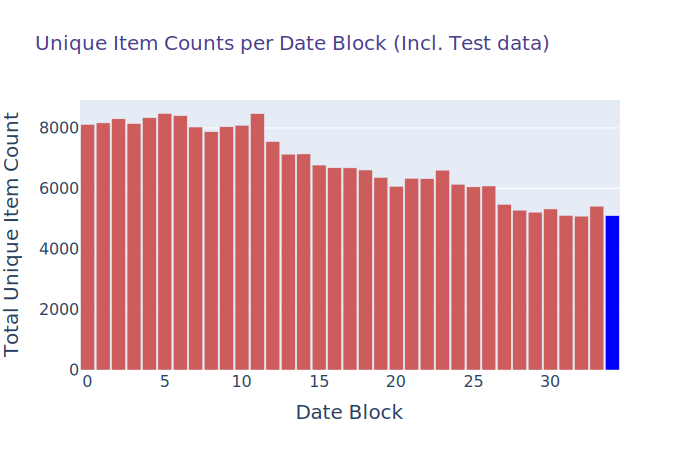

In [23]:
plot_counts(ft = 'item_id', name='Item')

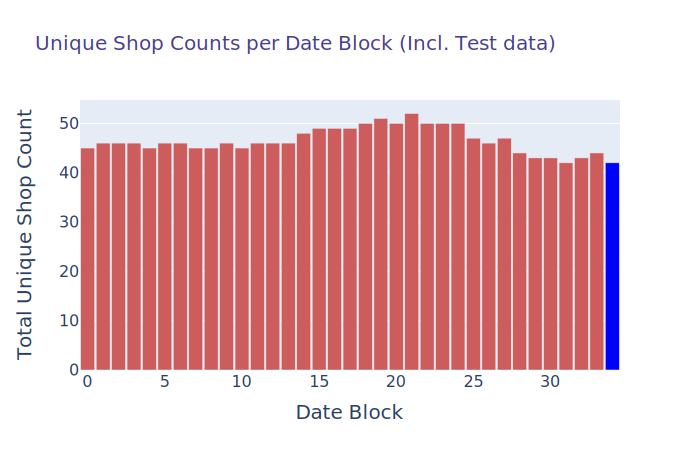

In [24]:
plot_counts(ft = 'shop_id', name='Shop')

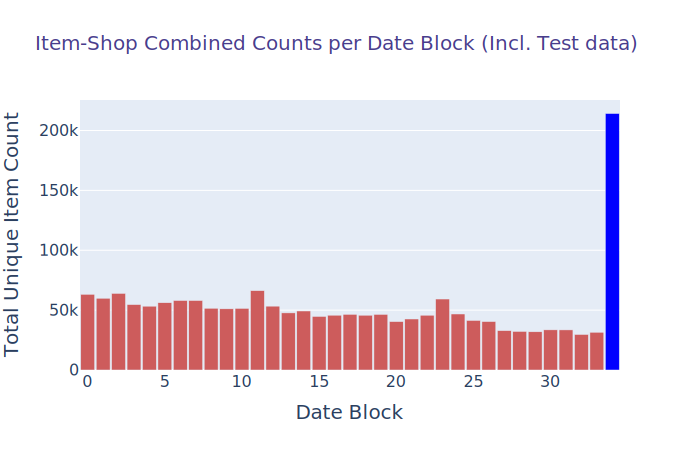

In [25]:
def plot_combined():
    fig = plotly.graph_objects.Figure()

    vizdata = train.append(test, ignore_index=True).groupby(by=['date_block_num'], as_index=False).size()

    colors = ['indianred',] * vizdata.shape[0]
    colors[-1] = 'blue'

    fig.add_trace(go.Bar(x=vizdata['date_block_num'],y=vizdata['size'],width=0.9,
                             marker_color=colors,name='Unique Item Count'))


    fig.update_xaxes(title_text='Date Block',titlefont=dict(size=20),
                     tickfont=dict(size=16))
    fig.update_yaxes(title_text='Total Unique Item Count',titlefont=dict(size=20),nticks=8,
                     tickfont=dict(size=16))

    fig.update_layout(height=800, width=800,
                      title=go.layout.Title(text='Item-Shop Combined Counts per Date Block (Incl. Test data)', 
                                            font=dict(size=20, color='darkslateblue')))
    '''Remove "svg" inside the parantheses below to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("svg")


plot_combined()

The last graph sure is a curveball.<br>
Test set contains all item/shop combinations, unlike the train set where **only** item/shop combinations **with sales** are included.<br><br> Below I'll be extending the train dataframe to include all item/shop combinations just like the test set.<br> Applying cartesian multiplication to each unique item and shop set per date block.

In [26]:
%%time

def extend_train():
    # Obtain set of date blocks
    dblocklist = train['date_block_num'].unique()

    # date and price lookup to be used below
    dblock_month = train[['date_block_num','date']].drop_duplicates().set_index('date_block_num').to_dict()['date']
    item_price = train.groupby(by=['item_id','date_block_num'])['item_price'].mean()

    # Get artesian product of shop/item pairs and append them to the list below
    train_extended_list = []
    for dblock in dblocklist:
        shops_dblock = train.loc[train['date_block_num'] == dblock, 'shop_id'].unique()
        items_dblock = train.loc[train['date_block_num'] == dblock, 'item_id'].unique()
        cartesian_prod = list(product(*[ items_dblock,shops_dblock, [dblock]]))
        train_extended_list.append(np.array(cartesian_prod))


    train_extended_list = np.vstack(train_extended_list)

    # Lookup the existing information from train set to the extended train set. 
    # Item price, item_cnt_month, and date features have nan's. 
    # Item_cnt_month nan --> fill with zero
    # Item price nan --> fill with avg. price for the date block (get the price from other shops' sales records)
    # Sale date --> Lookup based on date block num
    train_extended = pd.DataFrame(train_extended_list, columns=['item_id','shop_id','date_block_num'])
    train_extended = train_extended.merge(train, on=['item_id','shop_id','date_block_num'], how='left')
    train_extended['item_cnt_month'].fillna(0, inplace=True)

    train_extended['date'] = train_extended['date_block_num'].map(dblock_month)
    train_extended['item_price'] = train_extended.set_index(['item_id','date_block_num']).index.map(item_price)

    train_extended['train'] = 1
    test['train'] = 0

    return train_extended.append(test).reset_index(drop=True)

df = extend_train()

del train,test

CPU times: user 27.7 s, sys: 2.19 s, total: 29.9 s
Wall time: 29.9 s


Mapping relevant item and shop information from various files such as category id, category name, shop name to our dataframe.

In addition, I am extracting month and year from date column. Month number --> name conversion is to help with upcoming data-viz interpretation.

In [27]:
%%time


def get_cat_shop_date_info(df):
    itemsdf = pd.read_csv("items.csv")
    shopsdf = pd.read_csv("shops-translated.csv")
    itemcatsdf = pd.read_csv('categories_translated.csv')
    
    item_cat = dict(zip(itemsdf['item_id'],itemsdf['item_category_id']))
    item_cat_name = dict(zip(itemcatsdf['item_category_id'],itemcatsdf['item_category_name']))
    shop_name = dict(zip(shopsdf['shop_id'], shopsdf['shop_name_translated']))

    df['item_cat_id'] = df['item_id'].map(item_cat)
    df['item_cat_name'] = df['item_cat_id'].map(item_cat_name)
    df['shop_name'] = df['shop_id'].map(shop_name)
    
    df['month'] = df['date'].apply(lambda x: x.split(".")[1])
    df['year'] = df['date'].apply(lambda x: x.split(".")[2]).astype(str)

    month_name_lookup= {
        1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
        7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'
    }

    df['month'] = df['month'].astype(int).map(month_name_lookup)

    df.drop(columns='date', inplace=True)

    
    return df

df = get_cat_shop_date_info(df)

CPU times: user 8.87 s, sys: 1.18 s, total: 10.1 s
Wall time: 10.1 s


Applying downcasting function again, as we have new features

In [28]:
gc.collect()
df = downcast_df(df)

Memory use: 
                  |before downcasting|  |after downcasting|  |reduction (%)|
Index                            128                  128             0.00
item_id                     89024032             22256008            75.00
shop_id                     89024032             11128004            87.50
date_block_num              89024032             11128004            87.50
item_cnt_month              44512016             44512016             0.00
item_price                  89024032             44512016            50.00
train                       89024032             11128004            87.50
item_cat_id                 89024032             11128004            87.50
item_cat_name               89024032             89024032             0.00
shop_name                   89024032             89024032             0.00
month                       89024032             89024032             0.00
year                        89024032             89024032             0.00




Checking the number of items/shops/item categories that are in train set but not in test set, and vice versa. 

In [29]:
def check_only_in_one(first, second):
    if (first=='train'):
        i = 1
        j = 0
    else:
        i= 0
        j =1
    only_in_x_items = set(df.loc[df['train']==i,'item_id']) - set(df.loc[df['train']==j,'item_id'])
    only_in_x_cats = set(df.loc[df['train']==i,'item_cat_id']) - set(df.loc[df['train']==j,'item_cat_id'])
    only_in_x_shops = set(df.loc[df['train']==i,'shop_id']) - set(df.loc[df['train']==j,'shop_id'])
    nunique_x_items = df.loc[df['train']==i,'item_id'].nunique()
    nunique_x_cats = df.loc[df['train']==i,'item_cat_id'].nunique()
    nunique_x_shops = df.loc[df['train']==i,'shop_id'].nunique()
    if(len(only_in_x_items)>0):
        print(f'{len(only_in_x_items)} items are in {first} set but not in {second} set --> {len(only_in_x_items)/nunique_x_items:.0%} of items in {first}')
    if(len(only_in_x_cats)>0):
        print(f'{len(only_in_x_cats)} categories are in {first} set but not in {second} set --> {len(only_in_x_cats)/nunique_x_cats:.0%} of categories in {first}')
    if(len(only_in_x_shops)>0):
        print(f'{len(only_in_x_shops)} shops in {first} set but not in {second} set --> {len(only_in_x_shops)/nunique_x_shops:.0%} of shops in {first}')

In [30]:
check_only_in_one('train', 'test')

17069 items are in train set but not in test set --> 78% of items in train
22 categories are in train set but not in test set --> 26% of categories in train
18 shops in train set but not in test set --> 30% of shops in train


In [31]:
check_only_in_one('test', 'train')

363 items are in test set but not in train set --> 7% of items in test


For each shop, checking the date block range as well as unique items and categories

In [32]:
df.groupby(by=['shop_id','shop_name']).agg({'date_block_num':['min','max'],'item_cat_id':'nunique','item_id':'nunique'})

date_block_num      \
                                                                      min max   
shop_id shop_name                                                               
0       Yakutsk Ordzhonikidze, 56 francs                                0   1   
1       Yakutsk TC "Central" franc                                      0   1   
2       Adygea Shopping Center "Mega"                                   0  34   
3       Balashikha TRK "October-Kinomir"                                0  34   
4       Volzhsky shopping center "Volga Mall"                           0  34   
5       Vologda Shopping and Entertainment Center "Marm...              1  34   
6       Voronezh (Plekhanovskaya, 13)                                   0  34   
7       Voronezh TRC "Maksimir"                                         0  34   
8       Voronezh TRC City-Park "Grad"                                   0   3   
9       Outbound Trade                                                  9  33   
10      Zhukovsky Str. Chkalov 39m?                                     0  34   
11      Zhukovsky Str. Chkalov 39 m²                                   25  25   
12      Online shop Emergency                                           0  34   
13      Kazan TC "Behetle"                                              0  19   
14      Kazan TC "ParkHaus" II                                          0  34   
15      Kaluga TRC "XXI Century"                                        0  34   
16      Colosseum "Rio"                                                 0  34   
17      Krasnoyarsk Shopping center "Vzletka Plaza"                     5  24   
18      Krasnoyarsk Shopping center "June"                              0  34   
19      Kursk TC "Pushkinsky"                                           0  34   
20      Moscow "Sale"                                                  21  33   
21      Moscow MTRTS "Afi Mall"                                         0  34   
22      Moscow Shop С21                                                 0  34   
23      Moscow TC "Budenovskiy" (pav.A2)                                0   3   
24      Moscow TC "Budenovskiy" (pav.K7)                                0  34   
25      Moscow TRK "Atrium"                                             0  34   
26      Moscow Trade Center "Areal" (Belyaevo)                          0  34   
27      Moscow ТЦ "MEGA Belaya Dacha II"                                0  32   
28      Moscow ТЦ "MEGA Teply Stan" II                                  0  34   
29      Moscow TC "New Century" (Novokosino)                            0  28   
30      Moscow TP TPP "Perlovski"                                       0  25   
31      Moscow ТЦ "Семеновский"                                         0  34   
32      Moscow Shopping Center "Silver House"                           0   6   
33      Mytischi TRK "XL-3"                                            19  27   
34      N.Novgorod TRC "RIO"                                           18  34   
35      Nizhny Novgorod shopping mall "Fantastic"                       0  34   
36      Novosibirsk TRC "Gallery Novosibirsk"                          33  34   
37      Novosibirsk TC "Mega"                                           0  34   
38      Omsk TC "Mega"                                                  0  34   
39      RostovNaDon TRK "Megacenter Horizon"                           14  34   
40      RostovNaDonu TRC "Megacenter Horizon" Island                   14  24   
41      RostovNaDonu TC "Mega"                                          0  34   
42      SPb TC "Nevsky Center"                                          0  34   
43      SPb TK "Sennaya"                                                0  24   
44      Samara TP "Melody"                                              0  34   
45      Samara TC "ParkHaus"                                            0  34   
46      Sergiev Posad TC "7YA"                                          0  34   
47      S

A number of shops look duplicate/relocated. I will go ahead and combine those together.

In [33]:
df.loc[df['shop_id']==11,'shop_id'] = 10
df.loc[df['shop_id']==10,'shop_name'] = 'Zhukovsky st. Chkalov 39m?'
df.loc[df['shop_id']==0,'shop_id'] = 57
df.loc[df['shop_id']==57,'shop_name'] = 'Yakutsk Ordzhonikidze, 56'
df.loc[df['shop_id']==1,'shop_id'] = 58
df.loc[df['shop_id']==58,'shop_name'] = 'Yakutsk TC "Central\"'
df.loc[df['shop_id']==40,'shop_id'] = 39
df.loc[df['shop_id']==39,'shop_name'] = 'Rostov-on-Don Megacenter Horizon'

Plotting item prices against categories to see the potential outliers within each category. 

<ipython-input-34-13b9ec1f6177>:20: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



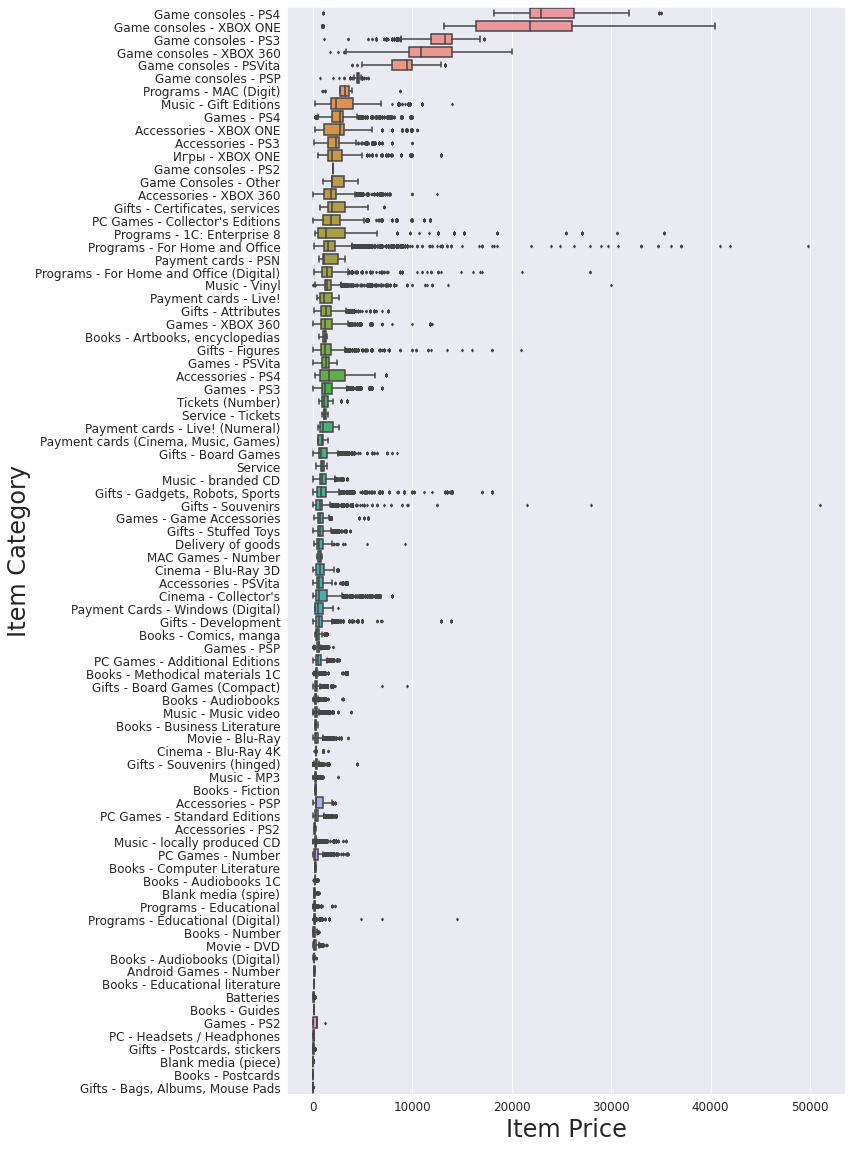

In [34]:
def plot_price_per_cat_shop(df,priceby, name):
    train_prices = df.loc[df['item_cnt_month']>0,['item_price','shop_name','item_cat_name']]

    sns.set_style('darkgrid')
    params={
        'axes.labelsize':24,
        'xtick.labelsize':12,
        'ytick.labelsize':12,
    }
    plt.rcParams.update(params)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,20))

    ordered = df.groupby(by=priceby)['item_price'].median().sort_values(ascending=False).index

    plot = sns.boxplot(y=train_prices[priceby],x=train_prices['item_price'], order=ordered, fliersize=2)

    plot.set_xlabel('Item Price')
    plot.set_ylabel(name)
    
    return fig.show()

plot_price_per_cat_shop(df, priceby='item_cat_name',name='Item Category')

Clipping prices per category to eliminate the outliers.

In [35]:
def clip_prices(df):
    for cat in df['item_cat_id'].unique():
        q25 = np.quantile(df.loc[(df['item_cnt_month']>0)&(df['item_cat_id']==cat),'item_price'],0.25)
        q75 = np.quantile(df.loc[(df['item_cnt_month']>0)&(df['item_cat_id']==cat),'item_price'],0.75)
        iqr = q75 - q25
        lower = q25 - 1.5*iqr
        upper = q75 + 1.5*iqr
        df.loc[df['item_cat_id']==cat,'item_price'] = df.loc[df['item_cat_id']==cat,'item_price'].clip(lower,upper)
        
    return df

df = clip_prices(df)

<ipython-input-34-13b9ec1f6177>:20: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



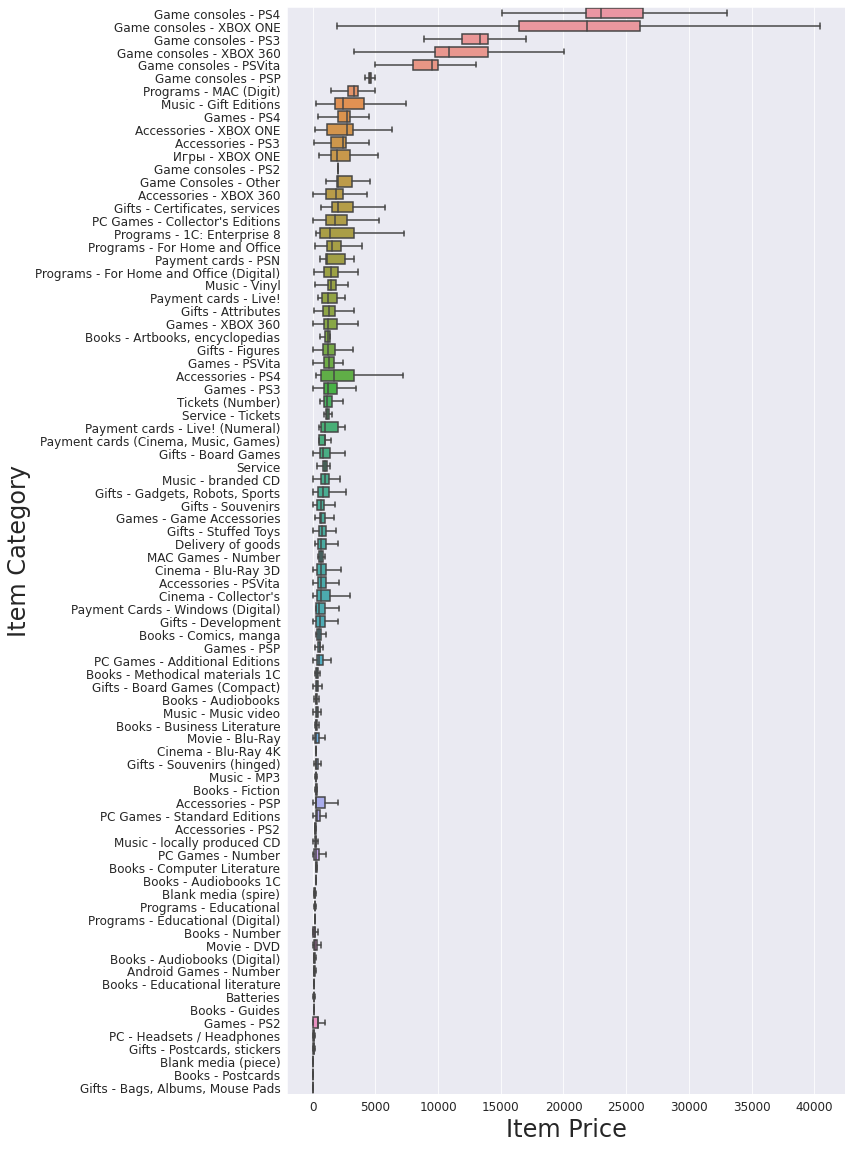

In [36]:
plot_price_per_cat_shop(df, priceby='item_cat_name',name='Item Category')

Looks better.

# Imputing Item Prices

The test set is missing all the price information. I'll be imputing those using the data from train set.<br> Applying imputation iteratively to make the most of the available information.

In [37]:
%%time
def get_nan_count(df, imputee):
    nancount = df['item_price'].isna().sum()
    if (nancount>0):
        print(f"Remaining nan counts after imputation using price per {imputee}: {nancount}")
    elif (nancount==0):
        print("No more missing values!")

def impute_test_prices(df):
    # Sorting the train dataframe to show most recent records at the top
    sorted_train = df[(df['train']==1)&(df['item_cnt_month']>0)].sort_values(by=['date_block_num'], ascending=False)

    # Obtaining the most recent avg. price per item/shop
    itemNshop_price = sorted_train.groupby(by=['item_id','shop_id'], sort=False)['item_price'].first()

    # Obtaining the most recent avg. price per item regardless of shop
    item_price = sorted_train.groupby(by=['item_id','date_block_num'],as_index=False, sort=False)['item_price'].mean()
    item_price = item_price.groupby(by=['item_id'],sort=False)['item_price'].first()

    # Obtaining the most recent avg. price per category/shop
    catNshop_price = sorted_train.groupby(by=['item_cat_id','shop_id','date_block_num'], as_index=False, sort=False)['item_price'].mean()
    catNshop_price = catNshop_price.groupby(by=['item_cat_id','shop_id'], sort=False)['item_price'].first()

    # Obtaining the most recent avg. price per category, regardless of shop
    cat_price = sorted_train.groupby(by=['item_cat_id','date_block_num'], as_index=False, sort=False)['item_price'].mean()
    cat_price = cat_price.groupby(by=['item_cat_id'], sort=False)['item_price'].first()

    # Imputing the missing item prices incrementally
    df.loc[df['item_price'].isna(),'item_price'] = df.loc[df['item_price'].isna()].set_index(['item_id','shop_id']).index.map(itemNshop_price).values
    get_nan_count(df, imputee = 'item and shop')

    df.loc[df['item_price'].isna(),'item_price'] = df.loc[df['item_price'].isna()].set_index(['item_id']).index.map(item_price).values
    get_nan_count(df, imputee = 'item')

    df.loc[df['item_price'].isna(),'item_price'] = df.loc[df['item_price'].isna()].set_index(['item_cat_id','shop_id']).index.map(catNshop_price).values
    get_nan_count(df, imputee = 'category and shop')
        
    df.loc[df['item_price'].isna(),'item_price'] = df.loc[df['item_price'].isna()].set_index(['item_cat_id']).index.map(cat_price).values
    get_nan_count(df, imputee = 'category')
        
    df.loc[df['item_price'].isna(),'item_price'] = df['item_price'].mean()
    get_nan_count(df, imputee = 'item (overall)')

    return df

df = impute_test_prices(df)

Remaining nan counts after imputation using price per item and shop: 102689
Remaining nan counts after imputation using price per item: 15246
Remaining nan counts after imputation using price per category and shop: 2228
No more missing values!
No more missing values!
CPU times: user 1.29 s, sys: 120 ms, total: 1.41 s
Wall time: 1.41 s


# Grouping Categoricals

Creating groups of item categories and extracting city information from shops.<br>

In [38]:
def map_cat_shop(df):
    category_mapping = {
        1:'Console Accessories', 2:'Console Accessories', 3:'Console Accessories', 
        4:'Console Accessories',5:'Console Accessories', 6:'Console Accessories',
        7:'Console Accessories', 25: 'Game Accessories',
        8:'Tickets', 42: 'Books', 43: 'Books', 44: 'Books', 
        45:'Books', 47: 'Books', 49: 'Books', 54: 'Books',
        46:'Books', 48: 'Books', 50: 'Books', 51: 'Books', 
        52:'Books', 53: 'Books', 11: 'Game Consoles', 12: 'Game Consoles', 
        15:'Game Consoles', 16: 'Game Consoles', 24: 'Games',
        10:'Game Consoles', 13: 'Game Consoles', 14: 'Game Consoles', 17: 'Game Consoles', 
        18: 'Games',32:'Payment Cards', 19: 'Games', 20: 'Games', 21: 'Games', 22: 'Games', 
        23: 'Games', 28: 'Games',29:'Games', 30: 'Games', 31: 'Games', 27: 'Mobile Games',
        61:'Gifts', 71: 'Gifts', 64: 'Gifts', 65: 'Gifts', 67: 'Gifts', 62: 'Gifts', 72: 'Gifts', 
        69: 'Gifts',70:'Gifts', 63: 'Gifts', 66: 'Gifts', 68: 'Gifts', 37: 'Movies', 40: 'Movies', 
        38: 'Movies', 41: 'Movies',39:'Movies', 60: 'Music', 57: 'Music', 58: 'Music', 56: 'Music', 
        55: 'Music', 59: 'Music', 33: 'Payment Cards',34:'Payment Cards', 35: 'Payment Cards', 
        36: 'Payment Cards', 73: 'Programs', 74: 'Programs', 75: 'Programs',76:'Programs', 
        77: 'Programs', 78: 'Programs', 26: 'Mobile Games', 83: 'Misc', 9: 'Misc', 0: 'Misc', 
        79: 'Office', 80: 'Misc',81:'Blank Media', 82: 'Blank Media'}

    shop_mapping = {
        0: 'Yakutsk',1: 'Yakutsk',2: 'Maykop', 3: 'Balashikha', 56: 'Chekhov', 
        55: 'Online', 12: 'Online', 15: 'Kaluga',13: 'Kazan', 14: 'Kazan', 
        54: 'Khimki', 16: 'Kolomna', 18: 'Krasnoyarsk', 17: 'Krasnoyarsk', 19: 'Kursk',
        20: 'Moscow', 21: 'Moscow', 30: 'Moscow', 22: 'Moscow', 26: 'Moscow', 24: 'Moscow',
        27: 'Moscow', 28: 'Moscow', 31: 'Moscow', 23: 'Moscow', 25: 'Moscow', 29: 'Moscow',
        32: 'Moscow', 33: 'Mytishchi', 34: 'Nizhny Novgorod', 35: 'Nizhny Novgorod', 
        36: 'Novosibirsk', 37: 'Novosibirsk', 9: 'Other',38: 'Omsk', 40: 'Rostov-on-Don', 
        39: 'Rostov-on-Don', 41: 'Rostov-on-Don', 42: 'Saint Petersburg', 43: 'Saint Petersburg', 
        44: 'Samara', 45: 'Samara',46: 'Sergiyev Posad', 47: 'Surgut', 48: 'Tomsk', 49: 'Tyumen', 
        50: 'Tyumen', 51: 'Tyumen', 52: 'Ufa', 53: 'Ufa', 5: 'Vologda',
        4: 'Volzhsky', 6: 'Voronezh', 7: 'Voronezh', 8: 'Voronezh', 57: 'Yakutsk', 
        58: 'Yakutsk', 59: 'Yaroslavl', 10: 'Zhukovsky', 11: 'Zhukovsky'}
    

    df['item_cat_group'] = df['item_cat_id'].map(category_mapping)
    df['city'] = df['shop_id'].astype(int).map(shop_mapping)
    
    return df

df = map_cat_shop(df)

# Visualizing Sales Quantities

I'll plot the sales numbers against date blocks, then against year and month.<br> 

Since we only have 10 months worth of data for the for 2015, I plot average sales alongside the total sales quantity. Average sales numbers will draw a more accurate picture compared to totals, in terms of month to month comparison. 

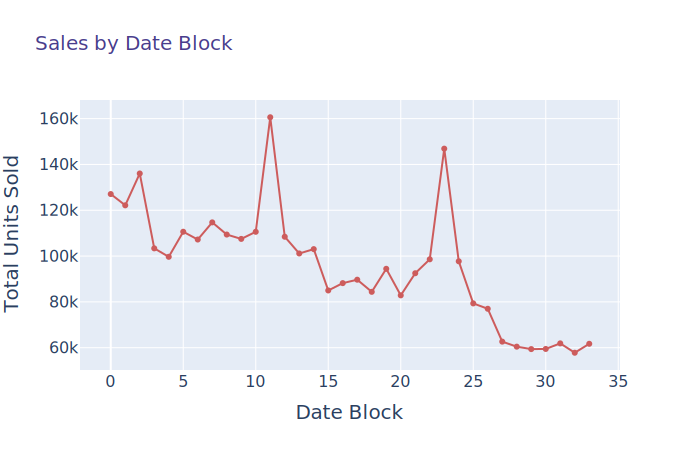

In [39]:
def plot_sales_per_dblock():
    fig = plotly.graph_objects.Figure()

    vizdata = df[df['train']==1].groupby(by=['date_block_num'], as_index=False).sum()


    fig.add_trace(go.Scatter(x=vizdata['date_block_num'],y=vizdata['item_cnt_month'],
                             marker_color='indianred',mode='lines+markers',name='Total Sales Qty'))



    fig.update_xaxes(title_text='Date Block',titlefont=dict(size=20),
                     tickfont=dict(size=16))
    fig.update_yaxes(title_text='Total Units Sold',titlefont=dict(size=20),nticks=8,
                     tickfont=dict(size=16))


    fig.update_layout(height=800, width=800,
                      title=go.layout.Title(text='Sales by Date Block', 
                                            font=dict(size=20, color='darkslateblue')))
    '''Remove "svg" inside the parantheses below to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("svg")

plot_sales_per_dblock()

Things to note:

* There is an overall downward trend
* There is seasonality
* Sales numbers increase significantly on December - this corresponds to date blocks 11 and 23.

Moving on with monthly/yearly graphs to understand the seasonality better.

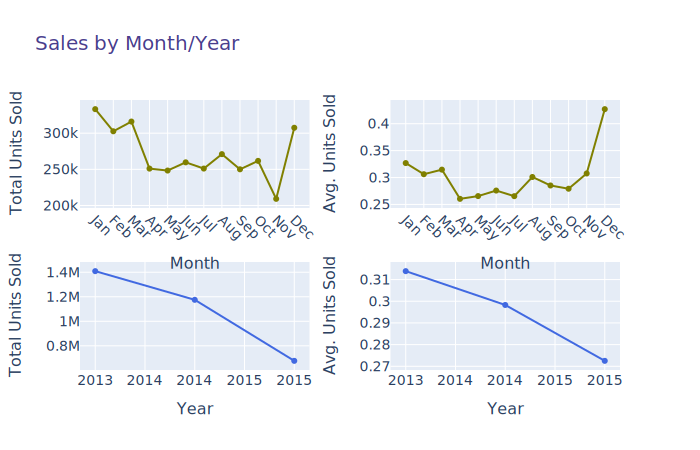

In [40]:
months = ['Jan', 'Feb',  'Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov' , 'Dec']

def plot_sales_per_mo_qu_yr(months):
    fig = make_subplots(rows=2, cols=2, vertical_spacing=0.2,horizontal_spacing=0.15)


    vizdata1a = df[df['train']==1].groupby(by=['month']).sum()['item_cnt_month'].reindex(months)
    vizdata1b = df[df['train']==1].groupby(by=['month']).mean()['item_cnt_month'].reindex(months)

    vizdata2a = df[df['train']==1].groupby(by=['year']).sum()['item_cnt_month'].sort_index()
    vizdata2b = df[df['train']==1].groupby(by=['year']).mean()['item_cnt_month'].sort_index()


    fig.add_trace(go.Scatter(x=vizdata1a.index,y=vizdata1a.values,marker_color='olive',
                             mode='lines+markers',name='total sales_by_month'),row=1, col=1)
    fig.add_trace(go.Scatter(x=vizdata1b.index,y=vizdata1b.values,marker_color='olive',
                             mode='lines+markers',name='avg sales_by_month'),row=1, col=2)


    fig.add_trace(go.Scatter(x=vizdata2a.index,y=vizdata2a.values,marker_color='royalblue',
                               mode='lines+markers',name='total sales_by_year'),row=2, col=1)
    fig.add_trace(go.Scatter(x=vizdata2b.index,y=vizdata2b.values,marker_color='royalblue',
                               mode='lines+markers',name='avg sales_by_year'),row=2, col=2)

    ticksize=14
    xstitlesize=16

    fig.update_xaxes(title_text='Month',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize),tickangle=45, row=1, col=1)
    fig.update_xaxes(title_text='Month',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize),tickangle=45, row=1, col=2)


    fig.update_xaxes(title_text='Year',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize), nticks=6, row=2, col=1,tickformat='.0f')
    fig.update_xaxes(title_text='Year',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize), nticks=6, row=2, col=2,tickformat='.0f')



    fig.update_yaxes(title_text='Total Units Sold',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize), row=1, col=1)
    fig.update_yaxes(title_text='Avg. Units Sold',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize), row=1, col=2)

    fig.update_yaxes(title_text='Total Units Sold',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize),row=2, col=1)
    fig.update_yaxes(title_text='Avg. Units Sold',titlefont=dict(size=xstitlesize),
                     tickfont=dict(size=ticksize), row=2, col=2)


    fig.update_layout(height=800, width=800,showlegend=False,
                      title=go.layout.Title(text='Sales by Month/Year',
                                            font=dict(size=20, color='darkslateblue')))

    '''Remove "svg" inside the parantheses below to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("svg")

plot_sales_per_mo_qu_yr(months)

Not surprisingly so - towards the end of a year, the sales numbers increase.
<br> There seems to be an ongoing decrease, as already noted, when we look at year over year sales numbers.

Now let's look at sales per category and per shop

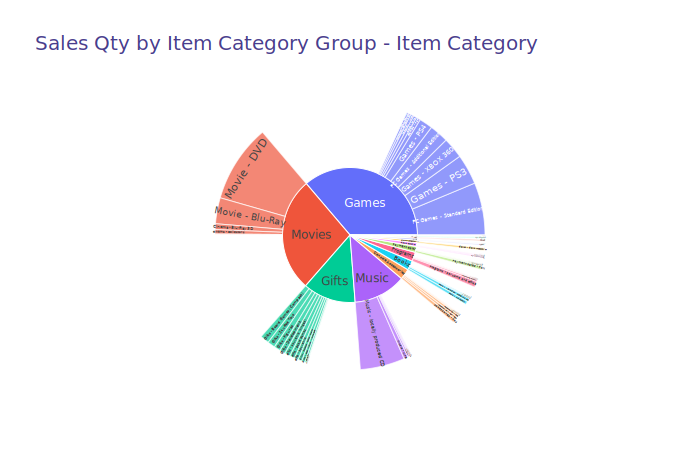

In [41]:
def plot_grouped_features(lvl1,lvl1name, lvl2, lvl2name):
    vizdata = df.loc[df['train']==1].groupby(by=[lvl2,lvl1], as_index=False).sum()

    labels = [*vizdata[lvl2].unique()]
    labels.extend([*vizdata[lvl1].values])

    parents = ['']*len([*vizdata[lvl2].unique()])
    parents.extend([*vizdata[lvl2].values])
    
    values = [*vizdata.groupby(by=lvl2)['item_cnt_month'].sum().values]
    values.extend([*vizdata['item_cnt_month'].values])

    fig = go.Figure(data=go.Sunburst(
        labels=labels,
        parents=parents,
        values= values
    ))

    fig.update_layout(
        width=900,height=900,
        title=go.layout.Title(text=f'Sales Qty by {lvl2name} - {lvl1name}',font=dict(size=20, color='darkslateblue')))
    
    '''Remove "svg" inside the parantheses below to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("svg")


plot_grouped_features('item_cat_name','Item Category','item_cat_group','Item Category Group')

Games and Movies make up the majority of the sales. This is normal considering the fact that the provider of the dataset is a software company. 

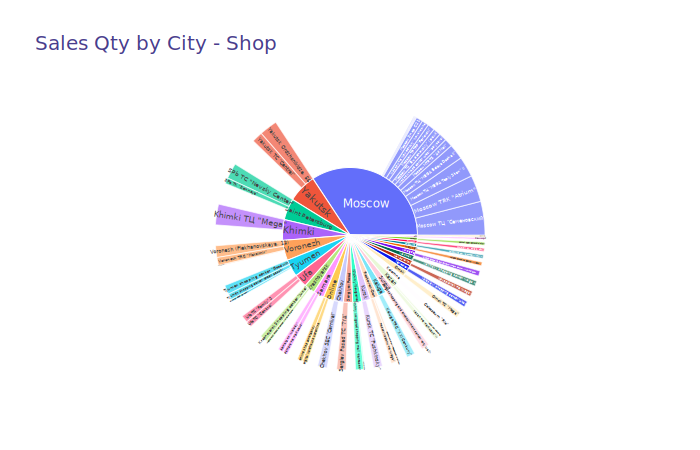

In [42]:
plot_grouped_features('shop_name','Shop','city','City')

Most of the sales takes place around Moscow area. Moscow is the cosmopolitan capital and the most populated city of Russia. So the graph above make sense to me.

# Binning Item Price

Binning the item price for visualization purposes

In [43]:
def bin_prices(df):
    kbd = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='quantile')

    # Binning the item price in train set
    df.loc[df['train']==1,'binned_item_price'] = kbd.fit_transform(df.loc[df['train']==1,'item_price'].values.reshape(-1,1))
    # Establishing binned item prices within test set
    df.loc[df['train']==0,'binned_item_price'] = kbd.transform(df.loc[df['train']==0,'item_price'].values.reshape(-1,1))
    # Getting the lower edge of bins to be used later during plotting
    item_lvl_bin_edges = dict(zip(range(kbd.n_bins),kbd.bin_edges_[0].astype(int)))
    
    return df, item_lvl_bin_edges

df, bin_edges = bin_prices(df)

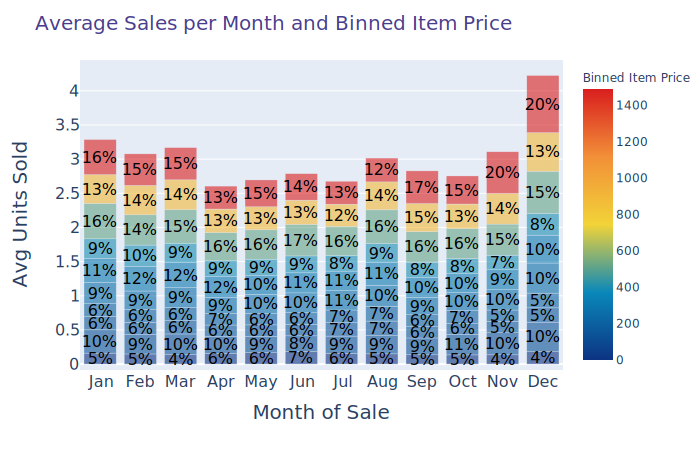

In [44]:
def plot_sales_per_bin(bin_edges):
    
    vizdata = df.loc[df['train']==1].groupby(by=['binned_item_price','month'], as_index=False).mean()
    vizdata['binned_item_price'] = vizdata['binned_item_price'].map(bin_edges)

    fig = go.Figure(px.bar(data_frame=vizdata,
                           y='item_cnt_month',
                           x='month',labels={'binned_item_price':'Binned Item Price'},
                           opacity=0.6, color='binned_item_price', 
                           color_continuous_scale=px.colors.diverging.Portland, orientation='v'))


    fig.update_xaxes(title_text='Month of Sale',titlefont=dict(size=20),tickfont=dict(size=16))
    fig.update_yaxes(title_text='Avg Units Sold',titlefont=dict(size=20),tickfont=dict(size=16),nticks=10)
    fig.update_layout(title=go.layout.Title(text='Average Sales per Month and Binned Item Price',font=dict(size=20, color='darkslateblue')))

    annot = []

    for x in set(vizdata['month']):
        record = vizdata.loc[vizdata['month']==x]
        yd = record['item_cnt_month'].values

        space=0
        for n in range(10):
            annot.append(dict(xref='x', yref='y',
                          y=space + yd[n]/2, x=x,
                          text='{0:.0%}'.format(yd[n]/yd.sum()),
                          font=dict(size=16,color='black',family='droid-sans'),
                          showarrow=False))
            space+=yd[n]


    fig.update_layout(height=1000, width=1000,annotations=annot,xaxis=dict(categoryarray=months,categoryorder='array'))

    '''Remove "svg" inside the parantheses to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("svg")


plot_sales_per_bin(bin_edges)

It's quite interesting to see that the demand for the most expensive items increase considerably during winter/holiday season.

# Setting Lag Features

The intent here is to reframe/convert the problem from time-series forecasting to supervised learning.<br> I will establish lag features (numbers representing sales from previous date block) to achieve that.<br><br> In addition, to have the model capture seasonality, I am establishing per month average sales.

In [45]:
%%time

def set_lag_features(df):
    # Indicating whether a record is a first sale for the item or not
    item_firstsale = df[df['item_cnt_month']>0].groupby(by=['item_id','shop_id'])['date_block_num'].min()
    df['item_firstsale_month'] = df.set_index(['item_id','shop_id']).index.map(item_firstsale)
    df['item_first_sale'] = 0
    df.loc[df['item_firstsale_month']==df['date_block_num'], 'item_first_sale'] = 1
    df.drop(columns=['item_firstsale_month'], inplace=True)


    #Average sales by month(**not dateblock**) across 3 years. 
    cat_avg_sales_month = df[df['train']==1].groupby(by=['item_cat_id','shop_id','month'])['item_cnt_month'].mean()
    item_avg_sales_month = df[df['train']==1].groupby(by=['item_id','shop_id','month'])['item_cnt_month'].mean()
    shop_avg_sales_month = df[df['train']==1].groupby(by=['shop_id','month'])['item_cnt_month'].mean()
    df['cat_avg_sales_month'] = df.set_index(['item_cat_id','shop_id','month']).index.map(cat_avg_sales_month)
    df['item_avg_sales_month'] = df.set_index(['item_id','shop_id','month']).index.map(item_avg_sales_month)
    df['shop_avg_sales_month'] = df.set_index(['shop_id','month']).index.map(shop_avg_sales_month)


    df[df['train']==1] = df[df['train']==1].sort_values(by=['date_block_num'])

    # Lag features
    df['item_cnt_month_t-1'] = df.groupby(by=['item_id','shop_id'],sort=False)['item_cnt_month'].shift(1).values
    df['item_cnt_month_t-2'] = df.groupby(by=['item_id','shop_id'],sort=False)['item_cnt_month'].shift(2).values
    df['item_cnt_month_t-3'] = df.groupby(by=['item_id','shop_id'],sort=False)['item_cnt_month'].shift(3).values

    df['item_avg_sales_month_t-1'] = df.groupby(by=['item_id','shop_id'],sort=False)['item_avg_sales_month'].shift(1).values
    df['item_avg_sales_month_t-2'] = df.groupby(by=['item_id','shop_id'],sort=False)['item_avg_sales_month'].shift(2).values
    df['item_avg_sales_month_t-3'] = df.groupby(by=['item_id','shop_id'],sort=False)['item_avg_sales_month'].shift(3).values

    df['cat_avg_month_t-1'] = df.groupby(by=['item_id','shop_id'],sort=False)['cat_avg_sales_month'].shift(1).values
    df['cat_avg_month_t-2'] = df.groupby(by=['item_id','shop_id'],sort=False)['cat_avg_sales_month'].shift(2).values
    df['cat_avg_month_t-3'] = df.groupby(by=['item_id','shop_id'],sort=False)['cat_avg_sales_month'].shift(3).values
    
    df['shop_avg_month_t-1'] = df.groupby(by=['item_id','shop_id'],sort=False)['shop_avg_sales_month'].shift(1).values
    df['shop_avg_month_t-2'] = df.groupby(by=['item_id','shop_id'],sort=False)['shop_avg_sales_month'].shift(2).values
    df['shop_avg_month_t-3'] = df.groupby(by=['item_id','shop_id'],sort=False)['shop_avg_sales_month'].shift(3).values

    return df.fillna(0)

df = set_lag_features(df)

CPU times: user 1min 33s, sys: 10.2 s, total: 1min 43s
Wall time: 1min 43s


# Identifying Similar Items

Calculating cosine similarities of item descriptions.<br> The idea here is that the items with similar vector directions have similar descriptions, therefore they are similar items (and may share similar sales trends). This hopefully helps the model forecast sales for items with no history.
<br>I identify 3 most similar items to each item in the dataset. The similar items will be used for target encoding.

In [46]:
def set_similar_items(df):
    itemstranslated = pd.read_csv("items-translated.csv")
    
    itemdf = pd.DataFrame(columns=["item_id","item_description"], data=itemstranslated.values)

    # Obtain a corpus of item descriptions
    corpus = list(itemdf["item_description"].values)

    # Vectorize each item description and calculate cosine similarity between each item/item combination, then store that info in a matrix.
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    cosine_similarities = pd.DataFrame(cosine_similarity(X), index=itemdf['item_id'], columns=itemdf['item_id'])

    # Pick the top 3 most similar items for each item
    similar_items = []
    for i in cosine_similarities.columns:
        similar = np.append(cosine_similarities[i].nlargest(4)[1:].index.values,i)
        similar_items.append(similar)
    similar_items = pd.DataFrame(np.vstack(similar_items), columns=['similar_item1','similar_item2','similar_item3','item_id'])


    # Append the similar item information back to our dataframe
    sim1 = dict(zip(similar_items['item_id'],similar_items['similar_item1']))
    sim2 = dict(zip(similar_items['item_id'],similar_items['similar_item2']))
    sim3 = dict(zip(similar_items['item_id'],similar_items['similar_item3']))
    df['similar_item1'] = df['item_id'].map(sim1)
    df['similar_item2'] = df['item_id'].map(sim2)
    df['similar_item3'] = df['item_id'].map(sim3)
    
    return df

df = set_similar_items(df)

In [47]:
df = downcast_df(df)

Memory use: 
                            |before downcasting|  |after downcasting|  \
Index                                      128                  128   
item_id                               22256008             22256008   
shop_id                               11128004             11128004   
date_block_num                        11128004             11128004   
item_cnt_month                        44512016             44512016   
item_price                            44512016             44512016   
train                                 11128004             11128004   
item_cat_id                           11128004             11128004   
item_cat_name                         89024032             89024032   
shop_name                             89024032             89024032   
month                                 89024032             89024032   
year                                  89024032             89024032   
item_cat_group                        89024032             890

Target encoding is a relatively memory-heavy operation.<br>
Thus, I am to see if there are any large objects that can be deleted to open up space before target encoding.

In [48]:
# Check memory consumption per file - and if necessary - delete large unused objects 
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df', 5566458750),
 ('TfidfVectorizer', 2008),
 ('KBinsDiscretizer', 1192),
 ('StandardScaler', 1064),
 ('XGBRegressor', 1064),
 ('product', 416),
 ('bin_edges', 360),
 ('y', 264),
 ('x', 184),
 ('months', 152),
 ('bin_prices', 136),
 ('check_only_in_one', 136),
 ('clip_prices', 136),
 ('cosine_similarity', 136),
 ('downcast_df', 136),
 ('extend_train', 136),
 ('get_cat_shop_date_info', 136),
 ('get_nan_count', 136),
 ('impute_test_prices', 136),
 ('make_subplots', 136),
 ('map_cat_shop', 136),
 ('plot_combined', 136),
 ('plot_counts', 136),
 ('plot_for_outlier', 136),
 ('plot_grouped_features', 136),
 ('plot_importance', 136),
 ('plot_price_per_cat_shop', 136),
 ('plot_sales_per_bin', 136),
 ('plot_sales_per_dblock', 136),
 ('plot_sales_per_mo_qu_yr', 136),
 ('set_lag_features', 136),
 ('set_similar_items', 136),
 ('go', 72),
 ('mticker', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('px', 72),
 ('sns', 72),
 ('fig', 48)]

The only large object is the main dataframe we're working with. The rest are peanuts. Moving on.

# Target encoding

Target encoding the categorical variables since a good chunk of the categoricals have very high cardinality. Otherwise I'd have tried to one-hot encode them.

In [49]:
%%time

encode_cols = [
    'city',
    'year',
    'item_id',
    'item_cat_id',
    'similar_item1',
    'similar_item2',
    'similar_item3',
    'item_cat_group'
]


def target_encode(df, cols):
    for col in cols:
        if (col not in ['city']):
            col = [col,'shop_id']
        else: col = [col]
        value_mapping = df[df['train']==1].groupby(by=col)['item_cnt_month'].mean()
        df[col[0]+"_encoded"] = df.set_index(col).index.map(value_mapping)
        df[col[0]+"_encoded"].fillna(value_mapping.mean(),inplace=True)
    return df

df = target_encode(df,encode_cols)

CPU times: user 1min 57s, sys: 13.6 s, total: 2min 11s
Wall time: 2min 11s


# **Feature Correlation Heatmap**

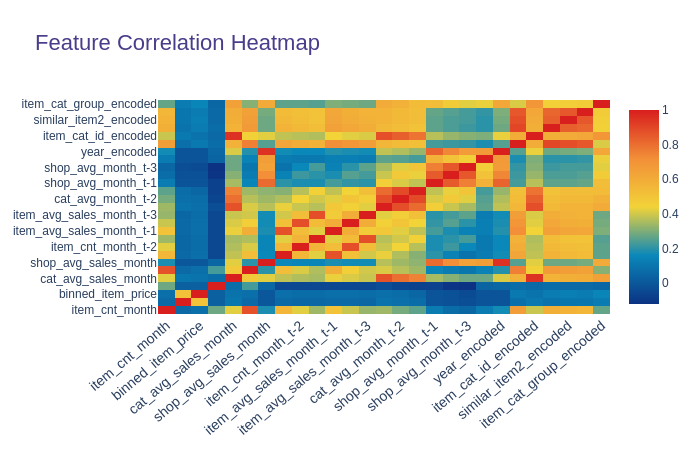

In [50]:
def plot_correlations(df):
    
    corr = df[df['train']==1].drop(columns=['item_cat_id','similar_item1','similar_item2','similar_item3',
                                            'city','item_id','train','shop_id','date_block_num']).corr()
    corr_cols = [*corr.columns.values]

    font_colors = ['white','black']

    fig = go.Figure(go.Heatmap(z=corr.round(2).values,x=corr_cols,y=corr_cols,colorscale=px.colors.diverging.Portland))

    fig.update_layout(height=40*len(corr_cols), width=40*len(corr_cols),
            title=go.layout.Title(text='Feature Correlation Heatmap',font=dict(size=22, color='darkslateblue')))

    fig.update_xaxes(tickfont=dict(size=14),tickangle=-40, side='bottom')
    
    '''Remove "png" inside the parantheses to enable interactive plotting. 
    For this you need a renderer that includes the embedded HTML/JavaScript 
    that makes up a plotly graph such as https://nbviewer.jupyter.org/'''
    return fig.show("png")

plot_correlations(df)

Dropping the redundant/unused features before starting the modeling step. 

In [51]:
X_cols_to_drop = [
    'item_id','shop_id','date_block_num','train',
    'item_cnt_month','binned_item_price',
    'item_cat_id','item_cat_name','shop_name',
    'similar_item1','similar_item2','similar_item3',
    'month','year','item_cat_group','city'
]

In [52]:
# Scaling item prices
scaler = StandardScaler()

df.loc[df['train']==1,'item_price'] = scaler.fit_transform(df.loc[df['train']==1,'item_price'].values.reshape(-1,1))
df.loc[df['train']==0,'item_price'] = scaler.transform(df.loc[df['train']==0,'item_price'].values.reshape(-1,1))

To mimic how the test set is created, I am setting aside the records with the date block num 33 for validation. This is different than the usual way of establishing validation sets e.g. cross_val, train_test_split etc.

In [53]:
def df_to_xy(df):
    
    X_train = df[df['date_block_num']<33].drop(columns=X_cols_to_drop)
    X_val = df[df['date_block_num']==33].drop(columns=X_cols_to_drop)

    y_train = df.loc[df['date_block_num']<33,'item_cnt_month']
    y_val = df.loc[df['date_block_num']==33,'item_cnt_month']

    X_test = df[df['date_block_num']==34].drop(columns=X_cols_to_drop)
    
    return X_test , X_train, X_val, y_train, y_val


X_test , X_train, X_val, y_train, y_val = df_to_xy(df)

del df
capture = gc.collect()

# Modeling, Feature Importances, and Final Submission

I am using XGB regressor for submission. The hyperparameter values are the result of a number of trial-and-errors.<br> I kept the tree relatively shallow with the intent of preventing overfitting.  

In [55]:
model_params = {
    'n_estimators':100,
    'max_depth':6,
    'booster':'gbtree',
    'learning_rate':0.15,
    'tree_method':'gpu_hist',
    'min_child_weight':0.35,
    'colsample_bytree':0.27,
    'subsample':0.93,
    'reg_alpha':0.83,
    'reg_lambda':0.56,
}


model = XGBRegressor(**model_params)
model.fit(X_train,y_train, eval_metric="rmse",eval_set=[(X_val, y_val)], early_stopping_rounds=10)

# Clipping the target values once more before submission
pred = model.predict(X_test).clip(0,20)

# Retrieving the submission IDs 
# sub_ID = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")['ID'].values
# submissionfile = pd.DataFrame(list(zip(sub_ID,pred)), columns=['ID','item_cnt_month'])

[0]	validation_0-rmse:1.04690
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.96270
[2]	validation_0-rmse:0.93373
[3]	validation_0-rmse:0.91125
[4]	validation_0-rmse:0.83990
[5]	validation_0-rmse:0.79247
[6]	validation_0-rmse:0.77122
[7]	validation_0-rmse:0.75026
[8]	validation_0-rmse:0.74580
[9]	validation_0-rmse:0.69024
[10]	validation_0-rmse:0.68779
[11]	validation_0-rmse:0.65842
[12]	validation_0-rmse:0.66160
[13]	validation_0-rmse:0.66288
[14]	validation_0-rmse:0.66268
[15]	validation_0-rmse:0.66456
[16]	validation_0-rmse:0.64936
[17]	validation_0-rmse:0.65332
[18]	validation_0-rmse:0.65962
[19]	validation_0-rmse:0.62786
[20]	validation_0-rmse:0.62717
[21]	validation_0-rmse:0.62619
[22]	validation_0-rmse:0.62599
[23]	validation_0-rmse:0.62609
[24]	validation_0-rmse:0.62745
[25]	validation_0-rmse:0.62876
[26]	validation_0-rmse:0.62748
[27]	validation_0-rmse:0.62778
[28]	validation_0-rmse:0.62853
[29]	validation_0-rmse:0.62904
[30]	validation

Visualizing feature importances.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

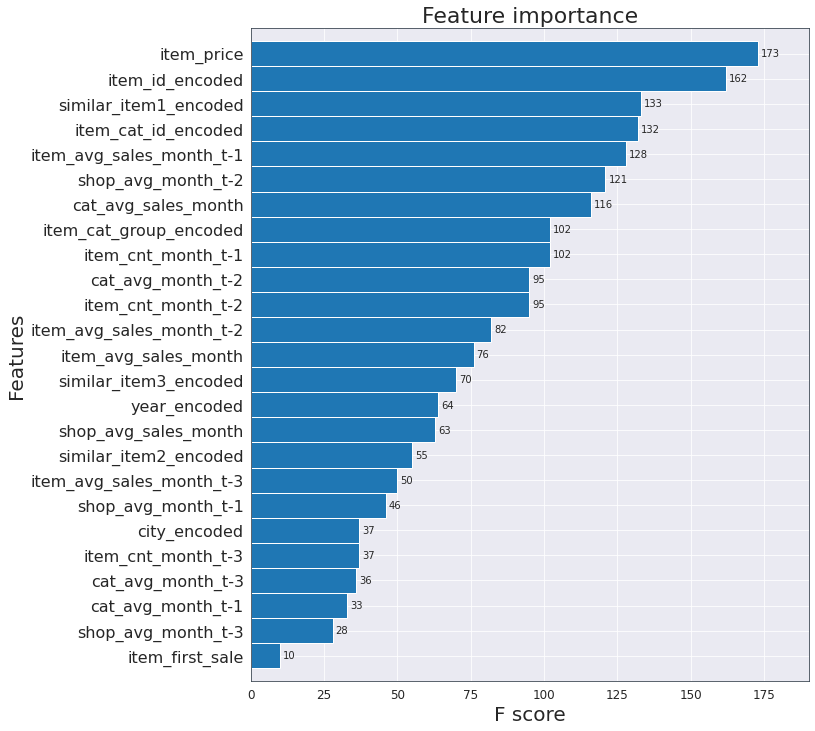

In [56]:
params={
    'axes.labelsize':20,
    'ytick.labelsize':16,
    'axes.titlesize':22,
    'axes.edgecolor':'#333F4B'
}
plt.rcParams.update(params)

fig, ax = plt.subplots(1,1,figsize=(10,12))

plot_importance(model, height=1, ax=ax)

Submitting the results...

In [56]:
# submissionfile.to_csv('submission.csv', index=False)